### ***UPDATE 06.03***  <a class='anchor' id='update'> </a> 
All chromosome were processed with the new pipline

In [1]:
import sys
import os
sys.path.append(os.path.abspath("code"))
# these are  needed-
import pandas as pd
import numpy as np
from GnomAD_df_class import GnomAD_df
pd.set_option('display.max_colwidth', 5000)

In [2]:
chrom_list = ['chr1', "chr2", "chr4","chr3","chr5", "chr6", "chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19", "chr20", "chr21", "chr22", "chrX", "chrY"]
def get_new_chrom_variant(chrom):
    """
    opens the new generated AF variant file 
    """
    df = pd.read_csv(f'data/gnomAD_AF/{chrom}_gnomAD_AF.tsv', sep='\t', header=None).loc[:,:4]
    df.columns = ['CHROM','POS','REF','ALT','NEW_AF']
    return df.set_index(['CHROM','POS','REF','ALT'])

def add_gnomAD_link(df):
    df = df.reset_index()
    links = []
    for i, row in df.iterrows():
        links.append(f"https://gnomad.broadinstitute.org/variant/{row.CHROM.replace('chr','')}-{row.POS}-{row.REF}-{row.ALT}?dataset=gnomad_r3")
    df['gnomAD'] = links
    func = lambda x: x if len(x) <= 5 else x[:5] + '...'
    df.REF = df.REF.apply(func)
    df.ALT = df.ALT.apply(func)
    return df


def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)


# Piplelines comparation

On the 1/3/2023 we noticed some of the samples do not have gnomAD's alleles frequencey (AF), Although it can be found on the website. <br>

In order to fix it, the script 'get_gnomAD_AF.sh', was applied. it can be found under "code folder   <br>
to run it, the following command was applied
>```bash
>sbatch --mem 8G --killable --requeue -c 4 --array=0-23 -t 72:00:00 --wrap "code/get_gnomAD_AF.sh"
>```

<br>
The job is killable due the useage of all the lab resources on the cluster. it means the job have low priority. <br>
The following chromosmes ended the scripts without errors: <br>

- chr1
- chr2
- chr3
- chr4
- chr5
- chr6
- chr7
- chr8
- chr9
- chr10
- chr11
- chr12
- chr13
- chr14
- chr15
- chr16
- chr17
- chr18
- chr19
- chr20
- chr21
- chr22
- chrX
- chrY

while the reset reported **bgzf_read_block**. The "bgzf_read_block" error in bcftools usually indicates a problem with reading compressed data blocks in a BGZF file. <br>
there are two possible explanation for the error: <br> 
1. corrupt file
2. insufficient disk space or memory errors

Since we are using a file which is largely in use worldwide, the 2nd option is more likely, killable flag or insufficient memory given to the command.<br>


In the following part, I'll compare between the current AF to the new generated (w/o errors). <br>

First a table which contains AF from the current df and new one will be generated



In [3]:
# creating a table which contains the current AF column and the new AF column
# loading the current DF
current_df = GnomAD_df('data/main.prq',remove_unkown=False, remove_phased_gt=False).get_table() #removing filters to sabe time
AF_df = current_df[['AF']].dropna()
new_df = pd.concat([ get_new_chrom_variant(chrom) for chrom in chrom_list])
AF_df = pd.concat([AF_df, new_df], axis=1).reset_index()
AF_df = AF_df[AF_df.CHROM.isin(chrom_list)]
                  

applying filters
removing variants outside of peak interval
done
getting table


## REMEMBER - The analysis is only chromosome which completed the new pipeline w/o errore, therefore the difference in numbers --see [update](#update)

### common variants
Lets look on variants which appear in both of the pipeline

total_variants    126150
same_AF           126150
different_AF           0
dtype: int64

the table below give a sample of 10 variants which appear in both piple line with link to the variant gnomAD page-


,CHROM,POS,REF,ALT,AF,NEW_AF,gnomAD
0,chr1,64912759,T,C,0.000171,0.000171,https://gnomad.broadinstitute.org/variant/1-64912759-T-C?dataset=gnomad_r3
1,chr10,113705225,CT,C,0.884687,0.884687,https://gnomad.broadinstitute.org/variant/10-113705225-CT-C?dataset=gnomad_r3
2,chr3,127823218,T,C,0.580372,0.580372,https://gnomad.broadinstitute.org/variant/3-127823218-T-C?dataset=gnomad_r3
3,chr7,128454916,GC,G,1.000000,1.000000,https://gnomad.broadinstitute.org/variant/7-128454916-GC-G?dataset=gnomad_r3
4,chr20,22584603,G,T,0.021112,0.021112,https://gnomad.broadinstitute.org/variant/20-22584603-G-T?dataset=gnomad_r3
5,chr21,14773987,A,C,0.019832,0.019832,https://gnomad.broadinstitute.org/variant/21-14773987-A-C?dataset=gnomad_r3
6,chr2,182867574,G,A,0.019276,0.019276,https://gnomad.broadinstitute.org/variant/2-182867574-G-A?dataset=gnomad_r3
7,chr6,56693518,T,C,0.015173,0.015173,https://gnomad.broadinstitute.org/variant/6-56693518-T-C?dataset=gnomad_r3
8,chr19,52297546,A,G,0.002209,0.002209,https://gnomad.broadinstitute.org/variant/19-52297546-A-G?dataset=gnomad_r3
9,chr17,57507759,A,C,0.863608,0.863608,https://gnomad.broadinstitute.org/variant/17-57507759-A-C?dataset=gnomad_r3


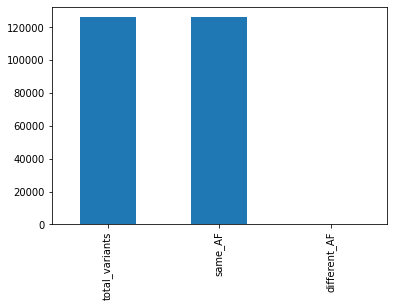

In [4]:
sum_both = pd.Series(dtype=np.float64)
both = AF_df.dropna()
sum_both['total_variants'] = both.shape[0]
sum_both['same_AF'] = (both.AF == both.NEW_AF).sum()
sum_both['different_AF'] = sum_both.total_variants - sum_both.same_AF
display(sum_both)
x = sum_both.plot.bar()
s = add_gnomAD_link(both.sample(10))
print('the table below give a sample of 10 variants which appear in both piple line with link to the variant gnomAD page-')
s.drop(columns='index').style.format({'gnomAD': make_clickable})

Variants which appear in both piplines share the same AF,<br>

By manualy looking on gnomAD, it can be seen the values are similar. <br>
Therefore I am pleased to say -  **mutral variants have the real gnomAD values in both piplines**

### Only in current table
The following will look into variants which appear in chromosomes which finished the new pipline without errors **BUT** only appear in the current table

total_variants    7987
dtype: int64

sample of 10 variants which appear only in current pipeline results


,CHROM,POS,REF,ALT,AF,NEW_AF,gnomAD
0,chr17,48619223,AGTGT...,"A,AGT",0.133981,nan,"https://gnomad.broadinstitute.org/variant/17-48619223-AGTGTGT-A,AGT?dataset=gnomad_r3"
1,chr7,100965955,G,C,0.499961,nan,https://gnomad.broadinstitute.org/variant/7-100965955-G-C?dataset=gnomad_r3
2,chrX,154762222,CA,C,0.978989,nan,https://gnomad.broadinstitute.org/variant/X-154762222-CA-C?dataset=gnomad_r3
3,chr3,184582277,TGCGC,"*,T",0.000017,nan,"https://gnomad.broadinstitute.org/variant/3-184582277-TGCGC-*,T?dataset=gnomad_r3"
4,chr6,32664576,G,"*,C",0.180974,nan,"https://gnomad.broadinstitute.org/variant/6-32664576-G-*,C?dataset=gnomad_r3"
5,chr12,57893471,G,"A,C",0.143681,nan,"https://gnomad.broadinstitute.org/variant/12-57893471-G-A,C?dataset=gnomad_r3"
6,chr3,194168498,GGT,"G,GGT...",0.109878,nan,"https://gnomad.broadinstitute.org/variant/3-194168498-GGT-G,GGTGT?dataset=gnomad_r3"
7,chr15,63324687,AT,"A,ATT...",0.045235,nan,"https://gnomad.broadinstitute.org/variant/15-63324687-AT-A,ATTTT?dataset=gnomad_r3"
8,chr10,125895996,C,A,0.473934,nan,https://gnomad.broadinstitute.org/variant/10-125895996-C-A?dataset=gnomad_r3
9,chr9,62801167,C,T,0.499544,nan,https://gnomad.broadinstitute.org/variant/9-62801167-C-T?dataset=gnomad_r3


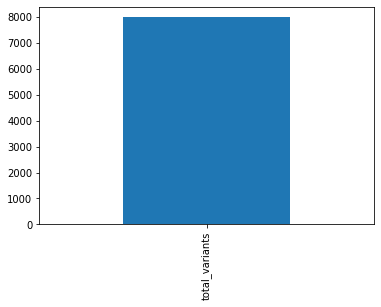

In [5]:
sum_current = pd.Series(dtype=np.float64)
only_current = AF_df[AF_df.AF.notna() & AF_df.NEW_AF.isna() ]
sum_current['total_variants'] = only_current.shape[0]
display(sum_current)
x = sum_current.plot.bar()
s = add_gnomAD_link(only_current.sample(10))
print("sample of 10 variants which appear only in current pipeline results")
s.drop(columns='index').style.format({'gnomAD': make_clickable})

There are 7987 variants which appear only in the current table. <br>
As it seems, some of them look wierd, and there is no data on them in gnomAD webstie. While variants which appears in gnomAD, does not pass the quality control. ( FILTER != PASS ) 

## UPDATE 6/3

It looks some variants appear on the old fule but not on the new

### Only new pipleline variant

now I'll look on variants which appear only in the new pipleline results

total_variants    22542704
dtype: int64

sample of 10 variants which appear only in new pipeline results


,CHROM,POS,REF,ALT,AF,NEW_AF,gnomAD
0,chr12,67543066,A,AGAAT...,nan,0.000118,https://gnomad.broadinstitute.org/variant/12-67543066-A-AGAATCCT?dataset=gnomad_r3
1,chr20,39524461,A,T,nan,0.000007,https://gnomad.broadinstitute.org/variant/20-39524461-A-T?dataset=gnomad_r3
2,chr2,112482323,C,T,nan,0.000007,https://gnomad.broadinstitute.org/variant/2-112482323-C-T?dataset=gnomad_r3
3,chr1,90177380,T,TA,nan,0.000383,https://gnomad.broadinstitute.org/variant/1-90177380-T-TA?dataset=gnomad_r3
4,chr1,27872479,C,T,nan,0.000008,https://gnomad.broadinstitute.org/variant/1-27872479-C-T?dataset=gnomad_r3
5,chr7,134892070,C,G,nan,0.000013,https://gnomad.broadinstitute.org/variant/7-134892070-C-G?dataset=gnomad_r3
6,chr9,37985411,C,T,nan,0.000033,https://gnomad.broadinstitute.org/variant/9-37985411-C-T?dataset=gnomad_r3
7,chr9,126631508,C,T,nan,0.000033,https://gnomad.broadinstitute.org/variant/9-126631508-C-T?dataset=gnomad_r3
8,chr3,128165223,G,T,nan,0.000007,https://gnomad.broadinstitute.org/variant/3-128165223-G-T?dataset=gnomad_r3
9,chr8,80578463,C,T,nan,0.000007,https://gnomad.broadinstitute.org/variant/8-80578463-C-T?dataset=gnomad_r3


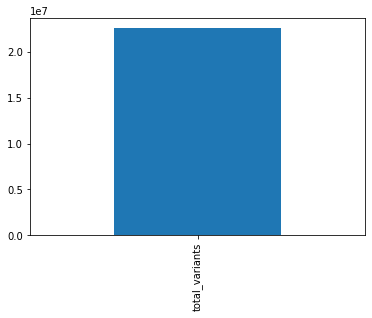

In [6]:
sum_new = pd.Series(dtype=np.float64)
only_new = AF_df[AF_df.AF.isna() & AF_df.NEW_AF.notna() ]
sum_new['total_variants'] = only_new.shape[0]
display(sum_new)
x = sum_new.plot.bar()
s = add_gnomAD_link(only_new.sample(10))
print("sample of 10 variants which appear only in new pipeline results")
s.drop(columns='index').style.format({'gnomAD': make_clickable})

It looks the AF numbers are same to gnomAD and the filter passed <br>
By that, I conclude we should use the new pipleline result.  <br>
I already started to run the pipline again on the missing chromosmes.<br>

Shabat Shalom, Ido

In [42]:

# new_af.columns = ['AF']
new_af.sort_index().to_parquet('data/gnomAD_AF.prq')

In [ ]:
current_df.loc[new_af[new_af.AF < 0.01].index]